In [2]:
# Cell 1: Imports and Paths
import pandas as pd
import numpy as np
import scipy.cluster.hierarchy as sch
from sklearn.covariance import LedoitWolf
import os
from datetime import datetime
from dateutil.relativedelta import relativedelta

# Define paths
data_path = r'C:/Users/lucas/OneDrive/Bureau/HRP/DATA (CRSP)/PREPROCESSED DATA/ADA-HRP-Preprocessed-DATA.csv'
rolling_dir = r'C:/Users/lucas/OneDrive/Bureau/HRP/DATA (CRSP)/Rolling Windows'
os.makedirs(rolling_dir, exist_ok=True)

In [4]:
# Cell 2: Load Data and Prepare Dates (Corrected Sorting)
# Load the data
df = pd.read_csv(data_path)

# Identify date columns
date_cols = [col for col in df.columns if col not in ['PERMNO', 'Company_Ticker']]

# Parse mangled column names to dates for sorting
parsed_strs = [col.replace('_', ':') for col in date_cols]
parsed_dates = pd.to_datetime(parsed_strs, errors='coerce')

# Sort by parsed dates
sort_order = np.argsort(parsed_dates)
date_cols = [date_cols[i] for i in sort_order]
dates = parsed_dates[sort_order]
date_strs = [d.strftime('%Y-%m-%d') for d in dates]

# Convert date columns to numeric
for col in date_cols:
    df[col] = pd.to_numeric(df[col], errors='coerce')

# Filter to stock rows only (exclude benchmarks)
stocks_df = df[df['PERMNO'].notna()].copy()

# Function to get quarterly end dates
def get_quarterly_dates(dates):
    quarterly_dates = []
    df_dates = pd.DataFrame({'date': dates})
    df_dates['year'] = df_dates['date'].dt.year
    df_dates['quarter'] = df_dates['date'].dt.quarter
    quarterly_ends = df_dates.groupby(['year', 'quarter'])['date'].max()
    return quarterly_ends.tolist()

quarterly_rebalance_dates = get_quarterly_dates(dates)

In [ ]:
def get_quasi_diag(link):
    link = link.astype(int)
    sort_ix = pd.Series([link[-1, 0], link[-1, 1]])
    num_items = link[-1, 3]
    while sort_ix.max() >= num_items:
        sort_ix.index = range(0, sort_ix.shape[0] * 2, 2)
        df0 = sort_ix[sort_ix >= num_items]
        i = df0.index
        j = df0.values - num_items
        sort_ix[i] = link[j, 0]
        df0 = pd.Series(link[j, 1], index=i + 1)
        sort_ix = pd.concat([sort_ix, df0])
        sort_ix = sort_ix.sort_index()
        sort_ix.index = range(sort_ix.shape[0])
    return sort_ix.tolist()

def get_cluster_var(cov, c_items):
    cov_ = cov.loc[c_items, c_items]
    ivp = 1 / np.diag(cov_)
    ivp /= ivp.sum()
    return (ivp @ cov_ @ ivp)

def get_recursive_bisection(cov, sort_ix):
    w = pd.Series(1.0, index=sort_ix)
    c_items = [sort_ix]
    while len(c_items) > 0:
        c_items = [i[j:k] for i in c_items for j, k in ((0, len(i) // 2), (len(i) // 2, len(i))) if len(i) > 1]
        for i in range(0, len(c_items), 2):
            c_items0 = c_items[i]
            c_items1 = c_items[i + 1]
            c_var0 = get_cluster_var(cov, c_items0)
            c_var1 = get_cluster_var(cov, c_items1)
            alpha = 1 - c_var0 / (c_var0 + c_var1)
            w[c_items0] *= alpha
            w[c_items1] *= 1 - alpha
    # Normalize to ensure weights sum to exactly 1.0 (fix numerical drift)
    w = w / w.sum()
    return w

In [ ]:
# Cell 4: Process Quarterly Rebalances and Compute HRP Weights (Unique Index Fix)
from tqdm import tqdm
from sklearn.metrics.pairwise import euclidean_distances

# Optimized Euclidean distance function
def get_euclidean_distance(dist):
    return pd.DataFrame(euclidean_distances(dist), index=dist.index, columns=dist.columns)

weights_list = []
for rebal_date in tqdm(quarterly_rebalance_dates):
    rebal_str = rebal_date.strftime('%Y-%m-%d')
    # Find the start of the 12-month lookback
    start_date = rebal_date - relativedelta(months=11)  # 12 periods including rebal_date
    window_dates = [d for d in dates if start_date <= d <= rebal_date]
    if len(window_dates) < 12:
        print(f"Skipping {rebal_str}: Insufficient data for 12-month window")
        continue
    
    window_strs = [d.strftime('%Y-%m-%d') for d in window_dates]
    
    # Map to actual mangled column names
    window_indices = [date_strs.index(s) for s in window_strs]
    actual_window_cols = [date_cols[i] for i in window_indices]
    
    # Select window data
    window_df = stocks_df[['PERMNO', 'Company_Ticker'] + actual_window_cols].copy()
    
    # Drop rows with NaN Company_Ticker if any
    window_df = window_df[window_df['Company_Ticker'].notna()]
    
    # Filter stocks with at least 12 valid (non-NaN) values in the window
    valid_mask = window_df[actual_window_cols].notna().sum(axis=1) >= 12
    window_df = window_df[valid_mask]
    
    if len(window_df) < 2:
        print(f"Skipping {rebal_str}: Fewer than 2 valid stocks")
        continue
    
    # Save the rolling window CSV
    window_path = os.path.join(rolling_dir, f'rolling_window_{rebal_str}.csv')
    window_df.to_csv(window_path, index=False)
    print(f"Saved rolling window for {rebal_str} to {window_path}")
    
    # Compute HRP weights using PERMNO as unique index
    returns = window_df[actual_window_cols].T  # Time x Assets
    returns.columns = window_df['PERMNO'].astype(str)  # Use PERMNO as unique columns (str)
    
    # Compute shrunk covariance using Ledoit-Wolf
    lw = LedoitWolf().fit(returns)
    cov_array = lw.covariance_
    cov = pd.DataFrame(cov_array, index=returns.columns, columns=returns.columns)
    
    # Compute correlation from shrunk cov
    std = np.sqrt(np.diag(cov_array))
    corr_array = cov_array / np.outer(std, std)
    corr = pd.DataFrame(corr_array, index=returns.columns, columns=returns.columns)
    
    # Distances
    dist = get_correlation_distance(corr)
    eucl_dist = get_euclidean_distance(dist)
    
    # Clustering
    link = sch.linkage(eucl_dist, method='single')
    
    # Seriation
    sort_ix = get_quasi_diag(link)
    sort_ix = returns.columns[sort_ix].tolist()  # List of str(PERMNO)
    
    # Weights
    hrp_weights = get_recursive_bisection(cov, sort_ix)
    
    # Map back to Company_Ticker
    permno_to_ticker = dict(zip(window_df['PERMNO'].astype(str), window_df['Company_Ticker']))
    
    # Store with Company_Ticker
    weights_df = pd.DataFrame({'PERMNO': hrp_weights.index, 'Weight': hrp_weights.values})
    weights_df['Company_Ticker'] = weights_df['PERMNO'].map(permno_to_ticker)
    weights_df = weights_df[['Company_Ticker', 'Weight']]  # Drop PERMNO if not needed
    weights_df['Rebalance_Date'] = rebal_str
    weights_list.append(weights_df)

# Combine all weights
all_weights = pd.concat(weights_list, ignore_index=True)
all_weights.to_csv(os.path.join(rolling_dir, 'hrp_weights_all.csv'), index=False)
print("Saved all HRP weights to hrp_weights_all.csv")

  0%|          | 0/180 [00:00<?, ?it/s]

Skipping 1980-03-31: Insufficient data for 12-month window
Skipping 1980-06-30: Insufficient data for 12-month window
Skipping 1980-09-30: Insufficient data for 12-month window
Saved rolling window for 1980-12-31 to C:/Users/lucas/OneDrive/Bureau/HRP/DATA (CRSP)/Rolling Windows\rolling_window_1980-12-31.csv


C:\Users\lucas\AppData\Local\Temp\ipykernel_18656\3582684607.py:63: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  link = sch.linkage(eucl_dist, method='single')
  2%|▏         | 4/180 [03:28<2:33:01, 52.17s/it]

Saved rolling window for 1981-03-31 to C:/Users/lucas/OneDrive/Bureau/HRP/DATA (CRSP)/Rolling Windows\rolling_window_1981-03-31.csv


C:\Users\lucas\AppData\Local\Temp\ipykernel_18656\3582684607.py:63: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  link = sch.linkage(eucl_dist, method='single')
  3%|▎         | 5/180 [06:42<4:20:32, 89.33s/it]

Saved rolling window for 1981-06-30 to C:/Users/lucas/OneDrive/Bureau/HRP/DATA (CRSP)/Rolling Windows\rolling_window_1981-06-30.csv


C:\Users\lucas\AppData\Local\Temp\ipykernel_18656\3582684607.py:63: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  link = sch.linkage(eucl_dist, method='single')
  3%|▎         | 6/180 [09:28<5:19:48, 110.28s/it]

Saved rolling window for 1981-09-30 to C:/Users/lucas/OneDrive/Bureau/HRP/DATA (CRSP)/Rolling Windows\rolling_window_1981-09-30.csv


C:\Users\lucas\AppData\Local\Temp\ipykernel_18656\3582684607.py:63: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  link = sch.linkage(eucl_dist, method='single')
  4%|▍         | 7/180 [12:07<5:57:24, 123.95s/it]

Skipping 1981-12-31: Insufficient data for 12-month window
Saved rolling window for 1982-03-31 to C:/Users/lucas/OneDrive/Bureau/HRP/DATA (CRSP)/Rolling Windows\rolling_window_1982-03-31.csv


C:\Users\lucas\AppData\Local\Temp\ipykernel_18656\3582684607.py:63: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  link = sch.linkage(eucl_dist, method='single')
  5%|▌         | 9/180 [14:57<5:04:07, 106.71s/it]

Saved rolling window for 1982-06-30 to C:/Users/lucas/OneDrive/Bureau/HRP/DATA (CRSP)/Rolling Windows\rolling_window_1982-06-30.csv


C:\Users\lucas\AppData\Local\Temp\ipykernel_18656\3582684607.py:63: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  link = sch.linkage(eucl_dist, method='single')
  6%|▌         | 10/180 [18:06<5:58:17, 126.46s/it]

Saved rolling window for 1982-09-30 to C:/Users/lucas/OneDrive/Bureau/HRP/DATA (CRSP)/Rolling Windows\rolling_window_1982-09-30.csv


C:\Users\lucas\AppData\Local\Temp\ipykernel_18656\3582684607.py:63: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  link = sch.linkage(eucl_dist, method='single')
  6%|▌         | 11/180 [21:03<6:33:10, 139.59s/it]

Skipping 1982-12-31: Insufficient data for 12-month window
Saved rolling window for 1983-03-31 to C:/Users/lucas/OneDrive/Bureau/HRP/DATA (CRSP)/Rolling Windows\rolling_window_1983-03-31.csv


C:\Users\lucas\AppData\Local\Temp\ipykernel_18656\3582684607.py:63: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  link = sch.linkage(eucl_dist, method='single')
  7%|▋         | 13/180 [23:54<5:24:49, 116.70s/it]

Saved rolling window for 1983-06-30 to C:/Users/lucas/OneDrive/Bureau/HRP/DATA (CRSP)/Rolling Windows\rolling_window_1983-06-30.csv


C:\Users\lucas\AppData\Local\Temp\ipykernel_18656\3582684607.py:63: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  link = sch.linkage(eucl_dist, method='single')
  8%|▊         | 14/180 [26:42<5:55:52, 128.63s/it]

Skipping 1983-09-30: Insufficient data for 12-month window
Saved rolling window for 1983-12-30 to C:/Users/lucas/OneDrive/Bureau/HRP/DATA (CRSP)/Rolling Windows\rolling_window_1983-12-30.csv


C:\Users\lucas\AppData\Local\Temp\ipykernel_18656\3582684607.py:63: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  link = sch.linkage(eucl_dist, method='single')
  9%|▉         | 16/180 [29:52<5:14:32, 115.08s/it]

Skipping 1984-03-30: Insufficient data for 12-month window
Saved rolling window for 1984-06-29 to C:/Users/lucas/OneDrive/Bureau/HRP/DATA (CRSP)/Rolling Windows\rolling_window_1984-06-29.csv


C:\Users\lucas\AppData\Local\Temp\ipykernel_18656\3582684607.py:63: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  link = sch.linkage(eucl_dist, method='single')
 10%|█         | 18/180 [33:22<5:01:15, 111.58s/it]

Saved rolling window for 1984-09-28 to C:/Users/lucas/OneDrive/Bureau/HRP/DATA (CRSP)/Rolling Windows\rolling_window_1984-09-28.csv


C:\Users\lucas\AppData\Local\Temp\ipykernel_18656\3582684607.py:63: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  link = sch.linkage(eucl_dist, method='single')
 11%|█         | 19/180 [37:28<6:13:22, 139.15s/it]

Saved rolling window for 1984-12-31 to C:/Users/lucas/OneDrive/Bureau/HRP/DATA (CRSP)/Rolling Windows\rolling_window_1984-12-31.csv


C:\Users\lucas\AppData\Local\Temp\ipykernel_18656\3582684607.py:63: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  link = sch.linkage(eucl_dist, method='single')
 11%|█         | 20/180 [41:18<7:06:02, 159.76s/it]

Saved rolling window for 1985-03-29 to C:/Users/lucas/OneDrive/Bureau/HRP/DATA (CRSP)/Rolling Windows\rolling_window_1985-03-29.csv


C:\Users\lucas\AppData\Local\Temp\ipykernel_18656\3582684607.py:63: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  link = sch.linkage(eucl_dist, method='single')
 12%|█▏        | 21/180 [45:48<8:14:52, 186.75s/it]

Saved rolling window for 1985-06-28 to C:/Users/lucas/OneDrive/Bureau/HRP/DATA (CRSP)/Rolling Windows\rolling_window_1985-06-28.csv


C:\Users\lucas\AppData\Local\Temp\ipykernel_18656\3582684607.py:63: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  link = sch.linkage(eucl_dist, method='single')
 12%|█▏        | 22/180 [50:04<8:59:21, 204.82s/it]

Saved rolling window for 1985-09-30 to C:/Users/lucas/OneDrive/Bureau/HRP/DATA (CRSP)/Rolling Windows\rolling_window_1985-09-30.csv


C:\Users\lucas\AppData\Local\Temp\ipykernel_18656\3582684607.py:63: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  link = sch.linkage(eucl_dist, method='single')
 13%|█▎        | 23/180 [54:06<9:22:19, 214.90s/it]

Saved rolling window for 1985-12-31 to C:/Users/lucas/OneDrive/Bureau/HRP/DATA (CRSP)/Rolling Windows\rolling_window_1985-12-31.csv


C:\Users\lucas\AppData\Local\Temp\ipykernel_18656\3582684607.py:63: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  link = sch.linkage(eucl_dist, method='single')
 13%|█▎        | 24/180 [58:04<9:35:11, 221.23s/it]

Saved rolling window for 1986-03-31 to C:/Users/lucas/OneDrive/Bureau/HRP/DATA (CRSP)/Rolling Windows\rolling_window_1986-03-31.csv


C:\Users\lucas\AppData\Local\Temp\ipykernel_18656\3582684607.py:63: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  link = sch.linkage(eucl_dist, method='single')
 14%|█▍        | 25/180 [1:01:48<9:33:19, 221.93s/it]

Saved rolling window for 1986-06-30 to C:/Users/lucas/OneDrive/Bureau/HRP/DATA (CRSP)/Rolling Windows\rolling_window_1986-06-30.csv


C:\Users\lucas\AppData\Local\Temp\ipykernel_18656\3582684607.py:63: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  link = sch.linkage(eucl_dist, method='single')
 14%|█▍        | 26/180 [1:05:31<9:31:01, 222.48s/it]

Saved rolling window for 1986-09-30 to C:/Users/lucas/OneDrive/Bureau/HRP/DATA (CRSP)/Rolling Windows\rolling_window_1986-09-30.csv


C:\Users\lucas\AppData\Local\Temp\ipykernel_18656\3582684607.py:63: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  link = sch.linkage(eucl_dist, method='single')
 15%|█▌        | 27/180 [1:09:18<9:30:25, 223.70s/it]

Saved rolling window for 1986-12-31 to C:/Users/lucas/OneDrive/Bureau/HRP/DATA (CRSP)/Rolling Windows\rolling_window_1986-12-31.csv


C:\Users\lucas\AppData\Local\Temp\ipykernel_18656\3582684607.py:63: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  link = sch.linkage(eucl_dist, method='single')
 16%|█▌        | 28/180 [1:13:05<9:29:14, 224.70s/it]

Saved rolling window for 1987-03-31 to C:/Users/lucas/OneDrive/Bureau/HRP/DATA (CRSP)/Rolling Windows\rolling_window_1987-03-31.csv


C:\Users\lucas\AppData\Local\Temp\ipykernel_18656\3582684607.py:63: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  link = sch.linkage(eucl_dist, method='single')
 16%|█▌        | 29/180 [1:17:04<9:36:17, 228.99s/it]

Saved rolling window for 1987-06-30 to C:/Users/lucas/OneDrive/Bureau/HRP/DATA (CRSP)/Rolling Windows\rolling_window_1987-06-30.csv


C:\Users\lucas\AppData\Local\Temp\ipykernel_18656\3582684607.py:63: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  link = sch.linkage(eucl_dist, method='single')
 17%|█▋        | 30/180 [1:21:31<10:00:17, 240.12s/it]

Saved rolling window for 1987-09-30 to C:/Users/lucas/OneDrive/Bureau/HRP/DATA (CRSP)/Rolling Windows\rolling_window_1987-09-30.csv


C:\Users\lucas\AppData\Local\Temp\ipykernel_18656\3582684607.py:63: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  link = sch.linkage(eucl_dist, method='single')
 17%|█▋        | 31/180 [1:26:03<10:19:48, 249.59s/it]

Skipping 1987-12-31: Insufficient data for 12-month window
Saved rolling window for 1988-03-31 to C:/Users/lucas/OneDrive/Bureau/HRP/DATA (CRSP)/Rolling Windows\rolling_window_1988-03-31.csv


C:\Users\lucas\AppData\Local\Temp\ipykernel_18656\3582684607.py:63: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  link = sch.linkage(eucl_dist, method='single')
 18%|█▊        | 33/180 [1:31:51<8:46:33, 214.92s/it] 

Saved rolling window for 1988-06-30 to C:/Users/lucas/OneDrive/Bureau/HRP/DATA (CRSP)/Rolling Windows\rolling_window_1988-06-30.csv


C:\Users\lucas\AppData\Local\Temp\ipykernel_18656\3582684607.py:63: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  link = sch.linkage(eucl_dist, method='single')
 19%|█▉        | 34/180 [1:37:58<10:14:23, 252.49s/it]

Saved rolling window for 1988-09-30 to C:/Users/lucas/OneDrive/Bureau/HRP/DATA (CRSP)/Rolling Windows\rolling_window_1988-09-30.csv


C:\Users\lucas\AppData\Local\Temp\ipykernel_18656\3582684607.py:63: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  link = sch.linkage(eucl_dist, method='single')
 19%|█▉        | 35/180 [1:44:30<11:38:12, 288.91s/it]

Skipping 1988-12-30: Insufficient data for 12-month window
Skipping 1989-03-31: Insufficient data for 12-month window
Skipping 1989-06-30: Insufficient data for 12-month window
Saved rolling window for 1989-09-29 to C:/Users/lucas/OneDrive/Bureau/HRP/DATA (CRSP)/Rolling Windows\rolling_window_1989-09-29.csv


C:\Users\lucas\AppData\Local\Temp\ipykernel_18656\3582684607.py:63: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  link = sch.linkage(eucl_dist, method='single')
 22%|██▏       | 39/180 [1:49:24<6:15:50, 159.93s/it] 

Saved rolling window for 1989-12-29 to C:/Users/lucas/OneDrive/Bureau/HRP/DATA (CRSP)/Rolling Windows\rolling_window_1989-12-29.csv


C:\Users\lucas\AppData\Local\Temp\ipykernel_18656\3582684607.py:63: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  link = sch.linkage(eucl_dist, method='single')
 22%|██▏       | 40/180 [1:54:18<7:08:28, 183.63s/it]

Skipping 1990-03-30: Insufficient data for 12-month window
Saved rolling window for 1990-06-29 to C:/Users/lucas/OneDrive/Bureau/HRP/DATA (CRSP)/Rolling Windows\rolling_window_1990-06-29.csv


C:\Users\lucas\AppData\Local\Temp\ipykernel_18656\3582684607.py:63: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  link = sch.linkage(eucl_dist, method='single')
 23%|██▎       | 42/180 [1:59:05<6:31:24, 170.18s/it]

Saved rolling window for 1990-09-28 to C:/Users/lucas/OneDrive/Bureau/HRP/DATA (CRSP)/Rolling Windows\rolling_window_1990-09-28.csv


C:\Users\lucas\AppData\Local\Temp\ipykernel_18656\3582684607.py:63: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  link = sch.linkage(eucl_dist, method='single')
 24%|██▍       | 43/180 [2:03:52<7:19:46, 192.60s/it]

Saved rolling window for 1990-12-31 to C:/Users/lucas/OneDrive/Bureau/HRP/DATA (CRSP)/Rolling Windows\rolling_window_1990-12-31.csv


C:\Users\lucas\AppData\Local\Temp\ipykernel_18656\3582684607.py:63: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  link = sch.linkage(eucl_dist, method='single')
 24%|██▍       | 44/180 [2:09:00<8:13:07, 217.55s/it]

Saved rolling window for 1991-03-28 to C:/Users/lucas/OneDrive/Bureau/HRP/DATA (CRSP)/Rolling Windows\rolling_window_1991-03-28.csv


C:\Users\lucas\AppData\Local\Temp\ipykernel_18656\3582684607.py:63: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  link = sch.linkage(eucl_dist, method='single')
 25%|██▌       | 45/180 [2:14:21<9:04:34, 242.03s/it]

Saved rolling window for 1991-06-28 to C:/Users/lucas/OneDrive/Bureau/HRP/DATA (CRSP)/Rolling Windows\rolling_window_1991-06-28.csv


C:\Users\lucas\AppData\Local\Temp\ipykernel_18656\3582684607.py:63: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  link = sch.linkage(eucl_dist, method='single')
 26%|██▌       | 46/180 [2:19:52<9:50:49, 264.55s/it]

Saved rolling window for 1991-09-30 to C:/Users/lucas/OneDrive/Bureau/HRP/DATA (CRSP)/Rolling Windows\rolling_window_1991-09-30.csv


C:\Users\lucas\AppData\Local\Temp\ipykernel_18656\3582684607.py:63: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  link = sch.linkage(eucl_dist, method='single')
 26%|██▌       | 47/180 [2:24:46<10:03:36, 272.30s/it]

Saved rolling window for 1991-12-31 to C:/Users/lucas/OneDrive/Bureau/HRP/DATA (CRSP)/Rolling Windows\rolling_window_1991-12-31.csv


C:\Users\lucas\AppData\Local\Temp\ipykernel_18656\3582684607.py:63: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  link = sch.linkage(eucl_dist, method='single')
 27%|██▋       | 48/180 [2:29:26<10:03:23, 274.27s/it]

Saved rolling window for 1992-03-31 to C:/Users/lucas/OneDrive/Bureau/HRP/DATA (CRSP)/Rolling Windows\rolling_window_1992-03-31.csv


C:\Users\lucas\AppData\Local\Temp\ipykernel_18656\3582684607.py:63: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  link = sch.linkage(eucl_dist, method='single')
 27%|██▋       | 49/180 [2:34:02<10:00:10, 274.89s/it]

Saved rolling window for 1992-06-30 to C:/Users/lucas/OneDrive/Bureau/HRP/DATA (CRSP)/Rolling Windows\rolling_window_1992-06-30.csv


C:\Users\lucas\AppData\Local\Temp\ipykernel_18656\3582684607.py:63: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  link = sch.linkage(eucl_dist, method='single')
 28%|██▊       | 50/180 [2:38:36<9:55:06, 274.67s/it] 

Saved rolling window for 1992-09-30 to C:/Users/lucas/OneDrive/Bureau/HRP/DATA (CRSP)/Rolling Windows\rolling_window_1992-09-30.csv


C:\Users\lucas\AppData\Local\Temp\ipykernel_18656\3582684607.py:63: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  link = sch.linkage(eucl_dist, method='single')
 28%|██▊       | 51/180 [2:43:16<9:53:29, 276.04s/it]

Saved rolling window for 1992-12-31 to C:/Users/lucas/OneDrive/Bureau/HRP/DATA (CRSP)/Rolling Windows\rolling_window_1992-12-31.csv


C:\Users\lucas\AppData\Local\Temp\ipykernel_18656\3582684607.py:63: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  link = sch.linkage(eucl_dist, method='single')
 29%|██▉       | 52/180 [2:48:04<9:56:37, 279.67s/it]

Saved rolling window for 1993-03-31 to C:/Users/lucas/OneDrive/Bureau/HRP/DATA (CRSP)/Rolling Windows\rolling_window_1993-03-31.csv


C:\Users\lucas\AppData\Local\Temp\ipykernel_18656\3582684607.py:63: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  link = sch.linkage(eucl_dist, method='single')
 29%|██▉       | 53/180 [2:53:00<10:01:54, 284.37s/it]

Saved rolling window for 1993-06-30 to C:/Users/lucas/OneDrive/Bureau/HRP/DATA (CRSP)/Rolling Windows\rolling_window_1993-06-30.csv


C:\Users\lucas\AppData\Local\Temp\ipykernel_18656\3582684607.py:63: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  link = sch.linkage(eucl_dist, method='single')
 30%|███       | 54/180 [2:59:17<10:54:54, 311.86s/it]

Saved rolling window for 1993-09-30 to C:/Users/lucas/OneDrive/Bureau/HRP/DATA (CRSP)/Rolling Windows\rolling_window_1993-09-30.csv


C:\Users\lucas\AppData\Local\Temp\ipykernel_18656\3582684607.py:63: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  link = sch.linkage(eucl_dist, method='single')
 31%|███       | 55/180 [3:05:13<11:17:32, 325.22s/it]

Skipping 1993-12-31: Insufficient data for 12-month window
Saved rolling window for 1994-03-31 to C:/Users/lucas/OneDrive/Bureau/HRP/DATA (CRSP)/Rolling Windows\rolling_window_1994-03-31.csv


C:\Users\lucas\AppData\Local\Temp\ipykernel_18656\3582684607.py:63: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  link = sch.linkage(eucl_dist, method='single')
 32%|███▏      | 57/180 [3:09:44<8:07:42, 237.91s/it] 

Saved rolling window for 1994-06-30 to C:/Users/lucas/OneDrive/Bureau/HRP/DATA (CRSP)/Rolling Windows\rolling_window_1994-06-30.csv


C:\Users\lucas\AppData\Local\Temp\ipykernel_18656\3582684607.py:63: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  link = sch.linkage(eucl_dist, method='single')
 32%|███▏      | 58/180 [3:15:27<8:56:25, 263.81s/it]

Skipping 1994-09-30: Insufficient data for 12-month window
Saved rolling window for 1994-12-30 to C:/Users/lucas/OneDrive/Bureau/HRP/DATA (CRSP)/Rolling Windows\rolling_window_1994-12-30.csv


C:\Users\lucas\AppData\Local\Temp\ipykernel_18656\3582684607.py:63: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  link = sch.linkage(eucl_dist, method='single')
 33%|███▎      | 60/180 [3:22:44<8:10:29, 245.25s/it]

Skipping 1995-03-31: Insufficient data for 12-month window
Skipping 1995-06-30: Insufficient data for 12-month window
Saved rolling window for 1995-09-29 to C:/Users/lucas/OneDrive/Bureau/HRP/DATA (CRSP)/Rolling Windows\rolling_window_1995-09-29.csv


C:\Users\lucas\AppData\Local\Temp\ipykernel_18656\3582684607.py:63: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  link = sch.linkage(eucl_dist, method='single')
 35%|███▌      | 63/180 [3:29:57<6:25:34, 197.73s/it]

Saved rolling window for 1995-12-29 to C:/Users/lucas/OneDrive/Bureau/HRP/DATA (CRSP)/Rolling Windows\rolling_window_1995-12-29.csv


C:\Users\lucas\AppData\Local\Temp\ipykernel_18656\3582684607.py:63: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  link = sch.linkage(eucl_dist, method='single')
 36%|███▌      | 64/180 [3:37:37<7:55:01, 245.70s/it]

Skipping 1996-03-29: Insufficient data for 12-month window
Saved rolling window for 1996-06-28 to C:/Users/lucas/OneDrive/Bureau/HRP/DATA (CRSP)/Rolling Windows\rolling_window_1996-06-28.csv


C:\Users\lucas\AppData\Local\Temp\ipykernel_18656\3582684607.py:63: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  link = sch.linkage(eucl_dist, method='single')
 37%|███▋      | 66/180 [3:44:34<7:22:36, 232.95s/it]

Saved rolling window for 1996-09-30 to C:/Users/lucas/OneDrive/Bureau/HRP/DATA (CRSP)/Rolling Windows\rolling_window_1996-09-30.csv


C:\Users\lucas\AppData\Local\Temp\ipykernel_18656\3582684607.py:63: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  link = sch.linkage(eucl_dist, method='single')
 37%|███▋      | 67/180 [3:51:47<8:33:01, 272.40s/it]

Saved rolling window for 1996-12-31 to C:/Users/lucas/OneDrive/Bureau/HRP/DATA (CRSP)/Rolling Windows\rolling_window_1996-12-31.csv


C:\Users\lucas\AppData\Local\Temp\ipykernel_18656\3582684607.py:63: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  link = sch.linkage(eucl_dist, method='single')
 38%|███▊      | 68/180 [3:58:34<9:23:22, 301.81s/it]

Saved rolling window for 1997-03-31 to C:/Users/lucas/OneDrive/Bureau/HRP/DATA (CRSP)/Rolling Windows\rolling_window_1997-03-31.csv


C:\Users\lucas\AppData\Local\Temp\ipykernel_18656\3582684607.py:63: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  link = sch.linkage(eucl_dist, method='single')
 38%|███▊      | 69/180 [4:06:39<10:39:29, 345.67s/it]

Saved rolling window for 1997-06-30 to C:/Users/lucas/OneDrive/Bureau/HRP/DATA (CRSP)/Rolling Windows\rolling_window_1997-06-30.csv


C:\Users\lucas\AppData\Local\Temp\ipykernel_18656\3582684607.py:63: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  link = sch.linkage(eucl_dist, method='single')
 39%|███▉      | 70/180 [4:14:20<11:27:32, 375.02s/it]

Saved rolling window for 1997-09-30 to C:/Users/lucas/OneDrive/Bureau/HRP/DATA (CRSP)/Rolling Windows\rolling_window_1997-09-30.csv


C:\Users\lucas\AppData\Local\Temp\ipykernel_18656\3582684607.py:63: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  link = sch.linkage(eucl_dist, method='single')
 39%|███▉      | 71/180 [4:22:54<12:28:21, 411.94s/it]

Saved rolling window for 1997-12-31 to C:/Users/lucas/OneDrive/Bureau/HRP/DATA (CRSP)/Rolling Windows\rolling_window_1997-12-31.csv


C:\Users\lucas\AppData\Local\Temp\ipykernel_18656\3582684607.py:63: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  link = sch.linkage(eucl_dist, method='single')
 40%|████      | 72/180 [4:35:03<14:58:55, 499.40s/it]

Saved rolling window for 1998-03-31 to C:/Users/lucas/OneDrive/Bureau/HRP/DATA (CRSP)/Rolling Windows\rolling_window_1998-03-31.csv


C:\Users\lucas\AppData\Local\Temp\ipykernel_18656\3582684607.py:63: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  link = sch.linkage(eucl_dist, method='single')
 41%|████      | 73/180 [4:47:54<17:07:27, 576.14s/it]

Saved rolling window for 1998-06-30 to C:/Users/lucas/OneDrive/Bureau/HRP/DATA (CRSP)/Rolling Windows\rolling_window_1998-06-30.csv


C:\Users\lucas\AppData\Local\Temp\ipykernel_18656\3582684607.py:63: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  link = sch.linkage(eucl_dist, method='single')
 41%|████      | 74/180 [4:59:32<17:59:37, 611.11s/it]

Saved rolling window for 1998-09-30 to C:/Users/lucas/OneDrive/Bureau/HRP/DATA (CRSP)/Rolling Windows\rolling_window_1998-09-30.csv


C:\Users\lucas\AppData\Local\Temp\ipykernel_18656\3582684607.py:63: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  link = sch.linkage(eucl_dist, method='single')
 42%|████▏     | 75/180 [5:11:44<18:51:12, 646.41s/it]

Skipping 1998-12-31: Insufficient data for 12-month window
Saved rolling window for 1999-03-31 to C:/Users/lucas/OneDrive/Bureau/HRP/DATA (CRSP)/Rolling Windows\rolling_window_1999-03-31.csv


C:\Users\lucas\AppData\Local\Temp\ipykernel_18656\3582684607.py:63: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  link = sch.linkage(eucl_dist, method='single')
 43%|████▎     | 77/180 [5:22:12<14:10:28, 495.42s/it]

Saved rolling window for 1999-06-30 to C:/Users/lucas/OneDrive/Bureau/HRP/DATA (CRSP)/Rolling Windows\rolling_window_1999-06-30.csv


C:\Users\lucas\AppData\Local\Temp\ipykernel_18656\3582684607.py:63: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  link = sch.linkage(eucl_dist, method='single')
 43%|████▎     | 78/180 [5:32:42<14:58:13, 528.37s/it]

Saved rolling window for 1999-09-30 to C:/Users/lucas/OneDrive/Bureau/HRP/DATA (CRSP)/Rolling Windows\rolling_window_1999-09-30.csv


C:\Users\lucas\AppData\Local\Temp\ipykernel_18656\3582684607.py:63: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  link = sch.linkage(eucl_dist, method='single')
 44%|████▍     | 79/180 [5:42:13<15:08:08, 539.49s/it]

Skipping 1999-12-31: Insufficient data for 12-month window
Saved rolling window for 2000-03-31 to C:/Users/lucas/OneDrive/Bureau/HRP/DATA (CRSP)/Rolling Windows\rolling_window_2000-03-31.csv


C:\Users\lucas\AppData\Local\Temp\ipykernel_18656\3582684607.py:63: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  link = sch.linkage(eucl_dist, method='single')
 45%|████▌     | 81/180 [5:51:10<11:39:56, 424.21s/it]

Saved rolling window for 2000-06-30 to C:/Users/lucas/OneDrive/Bureau/HRP/DATA (CRSP)/Rolling Windows\rolling_window_2000-06-30.csv


C:\Users\lucas\AppData\Local\Temp\ipykernel_18656\3582684607.py:63: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  link = sch.linkage(eucl_dist, method='single')
 46%|████▌     | 82/180 [6:00:32<12:25:21, 456.34s/it]

Saved rolling window for 2000-09-29 to C:/Users/lucas/OneDrive/Bureau/HRP/DATA (CRSP)/Rolling Windows\rolling_window_2000-09-29.csv


C:\Users\lucas\AppData\Local\Temp\ipykernel_18656\3582684607.py:63: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  link = sch.linkage(eucl_dist, method='single')
 46%|████▌     | 83/180 [6:10:17<13:09:23, 488.28s/it]

Saved rolling window for 2000-12-29 to C:/Users/lucas/OneDrive/Bureau/HRP/DATA (CRSP)/Rolling Windows\rolling_window_2000-12-29.csv


C:\Users\lucas\AppData\Local\Temp\ipykernel_18656\3582684607.py:63: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  link = sch.linkage(eucl_dist, method='single')
 47%|████▋     | 84/180 [6:19:52<13:37:48, 511.13s/it]

Skipping 2001-03-30: Insufficient data for 12-month window
Saved rolling window for 2001-06-29 to C:/Users/lucas/OneDrive/Bureau/HRP/DATA (CRSP)/Rolling Windows\rolling_window_2001-06-29.csv


C:\Users\lucas\AppData\Local\Temp\ipykernel_18656\3582684607.py:63: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  link = sch.linkage(eucl_dist, method='single')


In [12]:
# Cell 5: Load HRP Weights and Prepare for Performance Calculation (Corrected)
all_weights = pd.read_csv(os.path.join(rolling_dir, 'hrp_weights_all_cuda.csv'))

# Get all unique rebalance dates from weights
rebal_dates_str = sorted(all_weights['Rebalance_Date'].unique())
rebal_dates = pd.to_datetime(rebal_dates_str)

# Get all monthly dates from the original data
all_dates = dates  # Already sorted datetime from Cell 2

# Prepare benchmark series
bench_df = df[df['PERMNO'].isna()]  # Benchmark rows
vwretd_row = bench_df[bench_df['Company_Ticker'] == 'Value Weighted Benchmark']
ewretd_row = bench_df[bench_df['Company_Ticker'] == 'Equally Weighted Benchmark']

# Create series for benchmarks with datetime index
vwretd = pd.Series(vwretd_row.iloc[0][date_cols].values, index=dates, name='vwretd')
ewretd = pd.Series(ewretd_row.iloc[0][date_cols].values, index=dates, name='ewretd')

# Sort by index
vwretd = vwretd.sort_index()
ewretd = ewretd.sort_index()

print(f"Loaded {len(all_weights)} weight entries")
print(f"Rebalance dates: {len(rebal_dates)}")

Loaded 884991 weight entries
Rebalance dates: 142


In [16]:
# Cell 6: Compute HRP Portfolio Monthly Returns (Corrected Column Access)
# Initialize list for portfolio returns
port_returns = pd.Series(index=dates, dtype=float)  # Use sorted datetime index
port_returns.name = 'HRP'

# Precompute stock returns matrix for faster access
stocks_indexed = stocks_df.set_index('Company_Ticker')

for t_idx, t in enumerate(dates):
    # Find the latest rebalance date <= t
    prev_rebal = max([rd for rd in rebal_dates if rd <= t], default=None)
    if prev_rebal is None:
        continue  # No weights yet
    
    # Get weights for that rebalance
    weights_df = all_weights[all_weights['Rebalance_Date'] == prev_rebal.strftime('%Y-%m-%d')]
    weights = weights_df.set_index('Company_Ticker')['Weight']
    
    # Get the mangled column name for this date
    col_name = date_cols[t_idx]
    
    # Find intersection of tickers (those in weights AND in current data)
    available_tickers = weights.index.intersection(stocks_indexed.index)
    if len(available_tickers) == 0:
        port_returns[t] = np.nan
        continue
    
    # Get aligned returns and weights using .loc with the SAME index
    # This ensures both series have identical index in the same order
    ret_at_t = stocks_indexed.loc[available_tickers, col_name]
    weights_aligned = weights.loc[available_tickers]
    
    # Now both ret_at_t and weights_aligned have the EXACT same index
    # Handle any NaN in returns
    valid = ret_at_t.notna()
    if valid.sum() == 0:
        port_returns[t] = np.nan
        continue
    
    # Filter to valid entries
    ret_valid = ret_at_t.loc[valid[valid].index]
    w_valid = weights_aligned.loc[valid[valid].index]
    w_valid /= w_valid.sum()  # Renormalize
    
    # Portfolio return
    port_returns[t] = (w_valid * ret_valid).sum()

# Drop NaN periods
port_returns = port_returns.dropna()
print(f"\n✓ Computed {len(port_returns)} monthly portfolio returns")


✓ Computed 529 monthly portfolio returns


In [17]:
# Cell 7: Compute Cumulative Returns
# Align all series to common index (starting from first HRP return)
start_date = port_returns.index.min()
vwretd = vwretd[vwretd.index >= start_date]
ewretd = ewretd[ewretd.index >= start_date]
port_returns = port_returns[port_returns.index >= start_date]

# Cumulative returns (assuming simple returns, cumprod(1 + r))
cum_hrp = (1 + port_returns).cumprod()
cum_vw = (1 + vwretd).cumprod()
cum_ew = (1 + ewretd).cumprod()

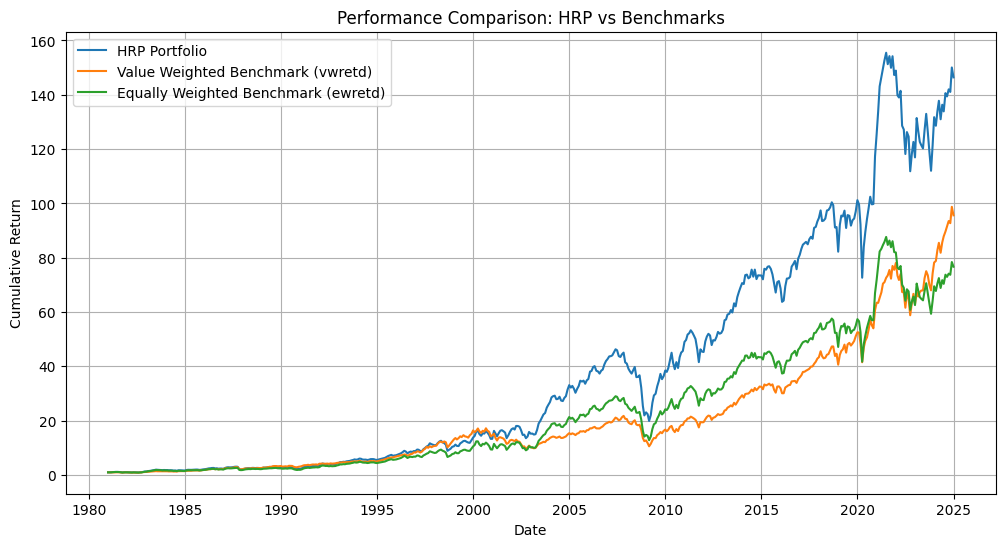

In [18]:
# Cell 8: Plot the Performance Comparison
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(cum_hrp.index, cum_hrp, label='HRP Portfolio')
plt.plot(cum_vw.index, cum_vw, label='Value Weighted Benchmark (vwretd)')
plt.plot(cum_ew.index, cum_ew, label='Equally Weighted Benchmark (ewretd)')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.title('Performance Comparison: HRP vs Benchmarks')
plt.legend()
plt.grid(True)
plt.show()